# Tasks

This version will try to improve:

- A: Introducing simulation to create a custom (nx,ny) shape after fitting... This should be simple.
- B: Scaling X1,X2,Y so that it can go higher order. DONE!
- C: Introducing sigma-clipping and iteration... This should be relatively hard.
- D: Clean up the order function... This might be hard.

In [1]:
# Test data
filename = './demo/idlk04bcq_flt.fits'
xref,yref = 488,542
bb0x,bb0y = 502,534
bb1x,bb1y = 684,553
padxleft,xwidth,padxright = 5,int(bb1x-xref),5
padylow,halfdy,padyup = 10,3,15

In [2]:
from polynomial2d.polynomial2d import Polynomial2D
import numpy as np
import matplotlib.pyplot as plt
import copy
from astropy.io import fits
import os
cwd = os.getcwd()

(529.0, 560.0)

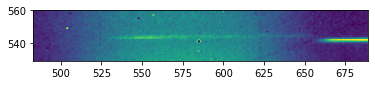

In [3]:
tmp = fits.open(filename)
tmpdata = tmp[1].data.copy()
m = np.where(np.isfinite(tmpdata))
vmin,vmax = np.percentile(tmpdata[m],5.),np.percentile(tmpdata[m],99.)
plt.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)
plt.xlim(xref-padxleft,xref+xwidth+padxright)
plt.ylim(yref-halfdy-padylow,yref+halfdy+padyup)


# Task B

In [4]:
##########
# create 2D x1,x2 grids
tmpx = int(xref-padxleft)
tmppx = int(xref+xwidth+padxright)
x1 = np.arange(tmpx,tmppx)

tmpy = int(yref-halfdy-padylow)
tmppy = int(1+yref+halfdy+padyup)
x2 = np.arange(tmpy,tmppy)

x1v,x2v = np.meshgrid(x1,x2)

##########
# cut the image for y
tmp = fits.open(filename)
tmpdata = tmp[1].data.copy()
y = tmpdata[tmpy:tmppy,tmpx:tmppx]

##########
# cut the data quality 'DQ' as mask
tmpdq = tmp['DQ'].data.copy()
tmp = np.full_like(tmpdq,True,dtype=bool)
m = np.where(tmpdq==0)
tmp[m] = False
mask = tmp[tmpy:tmppy,tmpx:tmppx]


In [5]:
rx1 = {'method':'linear'}
rx2 = {'method':'linear'}
ry = {'method':'linear'}
obj = Polynomial2D(x1=x1v,x2=x2v,y=y,mask=mask,norder=8,rescale=(True,rx1,rx2,ry))
obj.model
obj.fit()


Rescale = True

Exclude 0 invalid data points
data_minmax = (483.0,688.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (529.0,560.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,4.029854774475098) : scale_minmax = (-1.0,1.0) : method = linear


NameError: name 'mask' is not defined

In [ ]:
# 3D plots of y and mask (= 0 for good data)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
tmp = copy.deepcopy(obj.data)
ax.plot_surface(tmp['X1'],tmp['X2'],tmp['Y'],
                cmap='viridis'
               )
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.view_init(45,-90)



fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
tmp = copy.deepcopy(obj.data)
ax.plot_surface(tmp['X1'],tmp['X2'],tmp['MASK'].astype(int),
                cmap='Greys'
               )
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('MASK = 1')
ax.view_init(90,-90)


In [ ]:
# # fit()
# newobj.model['NORDER'] = 8
# newobj.fit()
# newobj.compute()

In [ ]:
# 3D plots of y and yfit
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
tmp = copy.deepcopy(obj.data)
ax.plot_surface(tmp['X1'],tmp['X2'],tmp['Y'],
                cmap='viridis',alpha=0.2
               )
ax.plot_surface(tmp['X1'],tmp['X2'],obj.model['YFIT'],
                cmap='Greys'
               )
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.view_init(40,-45)


# 3D plots of y - yfit
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
tmp = copy.deepcopy(obj.data)
ax.plot_surface(tmp['X1'],tmp['X2'],tmp['Y'] - obj.model['YFIT'],
                cmap='Greys'
               )

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.view_init(90,-90)


In [ ]:
tmpx1 = obj.rescale['X1'].transform(obj.data['X1'])
tmpx2 = obj.rescale['X2'].transform(obj.data['X2'])
tmpy = obj.rescale['Y'].transform(obj.data['Y'])
newobj = Polynomial2D(x1=tmpx1,x2=tmpx2,y=tmpy,mask=mask)
# fit()
newobj.model['NORDER'] = 8
newobj.fit()
newobj.compute()

In [ ]:
# # Kornpob Bhirombhakdi
# # kbhirombhakdi@stsci.edu

# from rescalex.rescale import Rescale
# import numpy as np
# import copy

# class Polynomial2D:
#     """
#     #########################################
#     ### Polynomial2D is a class containing data and methods to represent 2D polynomial function: y = f(x1,x2,norder,[cij]), where fij = cij * x1**i * x2**j and y = sum_{i=0}^{i=norder} sum_{j=0}^{j=i} fkj given k = i-j and k >= 0.
#     ### Polynomial2D().data = dict of data. These data are inputs, and will not be modified.
#     ### Polynomial2D().model = dict of data associated to a specified 2D polynomial model.
#     ### Polynomial2D().rescale = dict of specification for rescaling X1,X2,Y. 
#     ###    This can be specified by Polynomial2D(rescale=(a=bool,b,c,d)) where a = bool to specify whether rescaling would be performed.
#     ###    For b,c,d, each is a dict specifying arguments for rescalex.rescale.Rescale for X1,X2,Y respectively.
#     ###    For example, b = {'method'='linear','minmax'=(-1.,1.),'params':'None'}.
#     ###    Set b = None for not performing rescale with X1, and vice versa.
#     ### Polynomial2D().compute() = compute YFIT given a model and data.
#     ### Polynomial2D().fit() = fit for 2D polynomial coefficients given a model and data. This method includes an interation routine for outlier detection using outlierdetection.py.
#     ### Polynomial2D().test() = randomly simulate x1, x2, and coefficients given nsize and norder.
#     ### Polynomial2D().data['MASK'] keeps the original mask of data with False as good data.
#     ### Polynomial2D().model['MASKFIT'] keeps the latest mask from iterative fitting data and rejecting outliers.
#     Note: if rescale is performed, Polynomial2D().model['COEF'] results from rescaled space
#     while Polynomial2D().model['YFIT'] results in non-rescaled spcae.
#     #########################################
#     ### call: obj = Polynomial2D(x1,x2,y,mask,norder,coef,rescale)
#     ### call: obj.data['key'] for key = 'X1','X2','Y','MASK'
#     ### call: obj.model['key'] for key = 'NORDER','COEF',...(created using model)...
#     ### call: obj.rescale for examining rescaling results
#     x1,x2,y,mask must have the same dimensions.
#     mask, if not specified, is set to all False (= good data).
#     norder is non-negative integer representing the highest polynomial order.
#     coef is a dict of key:value = (i,j):cij where cij*x1**i*x2**j
#     #########################################
#     ### call: obj.compute() for computing polynomial2D using x1,x2,coef
#     ### call: obj.model['YFIT'] for the output
#     #########################################
#     ### call: obj.fit(niter,rejection={'TURN':'OFF'}) for fitting polynomial2D using x1,x2,y,maskfit,norder
#     obj.model['MASKFIT'] = obj.data['MASK'], if not specified.
#     maskfit = False for good data, and is used for the fitting.
#     maskfit, after iterations with rejection, is updated as the last iteration.
#     #########################################
#     ### call: obj.test(nsize,norder) for simulate x1,x2,coef
#     x1,x2 are 1d-vectors of size = nsize, each.
#     coef is obj.model['COEF'][(i,j)] = cij.
#     use obj.compute() to get yfit.
#     """
#     def __init__(self,x1=None,x2=None,y=None,mask=None,
#                  norder=None,coef=None,
#                  rescale=(False,None,None,None)
#                 ):
#         if (mask is None) and (x1 is not None):
#                 mask = np.full_like(x1,False,dtype=bool)
#         self.data = {'X1':x1,
#                      'X2':x2,
#                      'Y':y,
#                      'MASK':mask
#                       }
#         self.model = {'NORDER':norder,
#                       'COEF':coef,
#                       'YFIT':None,
#                       'MASKFIT':None
#                      }
#         self.rescale = {'RESCALE':rescale,
#                         'X1':None,
#                         'X2':None,
#                         'Y':None
#                        }
#         self._rescale()
#     ##########
#     ##########
#     def test(self,nsize=2,norder=2):
#         self.data['X1'] = np.random.uniform(low=-1.,high=1.,size=nsize)
#         self.data['X2'] = np.random.uniform(low=-1.,high=1.,size=nsize)
#         self.data['MASK'] = (self.data['X1']*0.).astype(bool)
#         self.model['NORDER'] = norder
#         tmp = np.random.uniform(low=-1.,high=1.,size=self._coefsize())
#         self.model['COEF'] = self._makecoef(tmp)
#         print('Simulate test')
#     ##########
#     ##########         
#     def compute(self):
#         x1 = self.data['X1']
#         x2 = self.data['X2']
#         norder = self.model['NORDER']
#         coef = self.model['COEF']
#         tmp = np.full_like(x1,0.,dtype=float)
#         for i in coef:
#             tmppowerx1,tmppowerx2 = i[0],i[1]
#             tmpcoef = coef[i]
#             tmpp = tmpcoef * np.power(x1,tmppowerx1) * np.power(x2,tmppowerx2)
#             tmp += tmpp
#         self.model['YFIT'] = tmp.copy()   
#         print('Perform compute')
#     ##########
#     ##########
#     def fit(self,niter=1,rejection={'TURN':'OFF'}):
#         if self.model['MASKFIT'] is None:
#             self.model['MASKFIT'] = self.data['MASK'].copy()
#         if self.rescale['RESCALE'][0]:
#             tmpx1 = self.rescale['X1'].transform(self.data['X1'])
#             tmpx2 = self.rescale['X2'].transform(self.data['X2'])
#             tmpy = self.rescale['Y'].transform(self.data['Y'])
#             tmpm = self.data['MASK'].copy()
#             newobj = Polynomial2D(x1=tmpx1,x2=tmpx2,y=tmpy,mask=mask)
#             newobj.model = copy.deepcopy(self.model)
#         else:
#             newobj = copy.deepcopy(self)
#         newobj._curvefit()
#         newobj.compute()
#         newobj.model['YFIT'] = self.rescale['Y'].invtransform(newobj.model['YFIT'])
#         self.model = copy.deepcopy(newobj.model)
#     ##########
#     ##########
#     def _rescale(self):
#         rescale = self.rescale['RESCALE']
#         x1,x2,y = self.data['X1'].copy(),self.data['X2'].copy(),self.data['Y'].copy()
#         KEY = {1:'X1',2:'X2',3:'Y'}
#         print('Rescale = {0}'.format(rescale[0]))
#         if not rescale[0]:
#             return
#         for i in KEY:
#             print('')
#             tmpdata = self.data[KEY[i]].copy()
#             rescale_arg_x = rescale[i]
#             obj = Rescale(data=tmpdata,**rescale_arg_x)
#             obj.compute()
#             self.rescale[KEY[i]] = copy.deepcopy(obj)
#     def _curvefit(self):
#         from scipy.optimize import curve_fit
#         x1 = self.data['X1'].copy()
#         x2 = self.data['X2'].copy()
#         y = self.data['Y'].copy()
#         norder = self.model['NORDER'] 
#         m = self.model['MASKFIT']
#         # check nan
#         mnan = np.where(~np.isfinite(y))
#         # update mask
#         m[mnan] = True
#         # apply mask
#         xx = x1[~m],x2[~m]
#         yy = y[~m]
#         print('Perform fit')        
#         if norder==0:
#             popt,pcov = curve_fit(self._n0,xx,yy)
#         elif norder==1:
#             popt,pcov = curve_fit(self._n1,xx,yy)
#         elif norder==2:
#             popt,pcov = curve_fit(self._n2,xx,yy)
#         elif norder==3:
#             popt,pcov = curve_fit(self._n3,xx,yy)
#         elif norder==4:
#             popt,pcov = curve_fit(self._n4,xx,yy)
#         elif norder==5:
#             popt,pcov = curve_fit(self._n5,xx,yy)
#         elif norder==6:
#             popt,pcov = curve_fit(self._n6,xx,yy)
#         elif norder==7:
#             popt,pcov = curve_fit(self._n7,xx,yy)
#         elif norder==8:
#             popt,pcov = curve_fit(self._n8,xx,yy)
#         else:
#             popt,pcov = None,None
#             print('Not support this norder')
#         self.model['COEF'] = self._makecoef(popt)
#         self.model['pcov'] = pcov
#     def _n0(self,x,c00):
#         return c00
#     def _n1(self,x,c00,c10,c01):
#         x1,x2=x
#         tmp = self._n0(x,c00)
#         tmp += c10*x1 + c01*x2
#         return tmp
#     def _n2(self,x,c00,c10,c01,c20,c11,c02):
#         x1,x2=x
#         tmp = self._n1(x,c00,c10,c01)
#         tmp += c20*np.power(x1,2) + c11*x1*x2 + c02*np.power(x2,2)
#         return tmp
#     def _n3(self,x,c00,c10,c01,c20,c11,c02,
#             c30,c21,c12,c03
#            ):
#         x1,x2=x
#         tmp = self._n2(x,c00,c10,c01,c20,c11,c02)
#         tmp += c30*np.power(x1,3) + c21*np.power(x1,2)*x2 + c12*x1*np.power(x2,2) + c03*np.power(x2,3)
#         return tmp
#     def _n4(self,x,c00,c10,c01,c20,c11,c02,
#             c30,c21,c12,c03,c40,c31,c22,c13,c04
#            ):
#         x1,x2=x
#         tmp = self._n3(x,c00,c10,c01,c20,c11,c02,
#                        c30,c21,c12,c03
#                       )
#         tmp += c40*np.power(x1,4) + c31*np.power(x1,3)*x2
#         tmp += c22*np.power(x1,2)*np.power(x2,2) + c13*x1*np.power(x2,3) + c04*np.power(x2,4)
#         return tmp
#     def _n5(self,x,c00,c10,c01,c20,c11,c02,
#             c30,c21,c12,c03,c40,c31,c22,c13,c04,
#             c50,c41,c32,c23,c14,c05
#            ):
#         x1,x2=x
#         tmp = self._n4(x,c00,c10,c01,c20,c11,c02,
#                        c30,c21,c12,c03,c40,c31,c22,c13,c04
#                       )
#         tmp += c50*np.power(x1,5) + c41*np.power(x1,4)*x2
#         tmp += c32*np.power(x1,3)*np.power(x2,2) + c23*np.power(x1,2)*np.power(x2,3) 
#         tmp += c14*x1*np.power(x2,4) + c05*np.power(x2,5)
#         return tmp
#     def _n6(self,x,c00,c10,c01,c20,c11,c02,
#             c30,c21,c12,c03,c40,c31,c22,c13,c04,
#             c50,c41,c32,c23,c14,c05,
#             c60,c51,c42,c33,c24,c15,c06
#            ):
#         x1,x2=x
#         tmp = self._n5(x,c00,c10,c01,c20,c11,c02,
#                        c30,c21,c12,c03,c40,c31,c22,c13,c04,
#                        c50,c41,c32,c23,c14,c05
#                       )
#         tmp += c60*np.power(x1,6) + c51*np.power(x1,5)*x2 + c42*np.power(x1,4)*np.power(x2,2)
#         tmp += c33*np.power(x1,3)*np.power(x2,3) + c24*np.power(x1,2)*np.power(x2,4) 
#         tmp += c15*x1*np.power(x2,5) + c06*np.power(x2,6)
#         return tmp
#     def _n7(self,x,c00,c10,c01,c20,c11,c02,
#             c30,c21,c12,c03,c40,c31,c22,c13,c04,
#             c50,c41,c32,c23,c14,c05,
#             c60,c51,c42,c33,c24,c15,c06,
#             c70,c61,c52,c43,c34,c25,c16,c07
#            ):
#         x1,x2=x
#         tmp = self._n6(x,c00,c10,c01,c20,c11,c02,
#                        c30,c21,c12,c03,c40,c31,c22,c13,c04,
#                        c50,c41,c32,c23,c14,c05,
#                        c60,c51,c42,c33,c24,c15,c06
#                       )
#         tmp += c70*np.power(x1,7) + c61*np.power(x1,6)*x2 + c52*np.power(x1,5)*np.power(x2,2)
#         tmp += c43*np.power(x1,4)*np.power(x2,3) + c34*np.power(x1,3)*np.power(x2,4) 
#         tmp += c25*np.power(x1,2)*np.power(x2,5) + c16*x1*np.power(x2,6) + c07*np.power(x2,7)
#         return tmp
#     def _n8(self,x,c00,c10,c01,c20,c11,c02,
#             c30,c21,c12,c03,c40,c31,c22,c13,c04,
#             c50,c41,c32,c23,c14,c05,
#             c60,c51,c42,c33,c24,c15,c06,
#             c70,c61,c52,c43,c34,c25,c16,c07,
#             c80,c71,c62,c53,c44,c35,c26,c17,c08
#            ):
#         x1,x2=x
#         tmp = self._n7(x,c00,c10,c01,c20,c11,c02,
#                        c30,c21,c12,c03,c40,c31,c22,c13,c04,
#                        c50,c41,c32,c23,c14,c05,
#                        c60,c51,c42,c33,c24,c15,c06,
#                        c70,c61,c52,c43,c34,c25,c16,c07
#                       )
#         tmp += c80*np.power(x1,8) + c71*np.power(x1,7)*x2 + c62*np.power(x1,6)*np.power(x2,2)
#         tmp += c53*np.power(x1,5)*np.power(x2,3) + c44*np.power(x1,4)*np.power(x2,4) 
#         tmp += c35*np.power(x1,3)*np.power(x2,5) + c26*np.power(x1,2)*np.power(x2,6) + c17*x1*np.power(x2,7)
#         tmp += c08*np.power(x2,8)
#         return tmp
#     ##########
#     ##########
#     def _coefsize(self):
#         NORDER = self.model['NORDER']
#         tmp = NORDER + 1
#         tmpp = 0
#         while (tmp > 0):
#             tmpp+=tmp
#             tmp-=1
#         return tmpp
#     def _makecoef(self,popt):
#         NORDER = self.model['NORDER']
#         COEF = {}
#         k = 0
#         for i in range(NORDER+1):
#             tmpi = copy.deepcopy(i)
#             tmpj = 0
#             while (tmpi>=0):
#                 COEF[(tmpi,tmpj)] = popt[k]
#                 tmpi-=1
#                 tmpj+=1
#                 k+=1
#         return COEF
#     ##########
#     ##########
